In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import glob
import re
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list, get_betamap_paths, Subject

# Parameters

In [4]:
statistic = 'z_score'
multiple_comp_corr = 'fpr'
alpha = 0.05
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/rsa_no_iti_20250310'

# First level parameters

In [5]:
# Find the first JSON file
json_file_path = glob.glob(os.path.join(first_level_dir, '**', '*_params.json'), recursive=True)[0]

# Load and print the JSON file contents
with open(json_file_path, 'r') as file:
    json_data = json.load(file)
    for key, value in json_data.items():
        print(f"{key}: {value}")

model_name: rsa_no_iti
tr: 2.33384
hrf_model: spm
noise_model: ar1
smoothing_fwhm: 5
motion_type: basic
include_physio: True
brain_mask: True
fd_thresh: 0.5
std_dvars_thresh: 2
exclusion_threshold: 0.2
scrub: dummies
duration: all
iti_included: False


# Load First level data

In [6]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [7]:
stimuli = [1, 2, 3, 4, 5, 6, 7, 8]

In [8]:
betamap_dict = {}
previous_found_subs = None

for stim in stimuli:
    betamap_paths, found_subs = get_betamap_paths(sub_ids, first_level_dir, run, f"sub-{{sub_id}}_run-{{run}}_betamap_first_stim_presentation_{stim}.nii.gz")
    betamap_dict[stim] = betamap_paths
    print(f"Found {len(betamap_paths)} beta maps for stimulus {stim}")
    
    if previous_found_subs is None:
        previous_found_subs = found_subs
    else:
        if found_subs != previous_found_subs:
            print(f"Warning: found_subs list has changed for stimulus {stim}")

Found 57 beta maps for stimulus 1
Found 57 beta maps for stimulus 2
Found 57 beta maps for stimulus 3
Found 57 beta maps for stimulus 4
Found 57 beta maps for stimulus 5
Found 57 beta maps for stimulus 6
Found 57 beta maps for stimulus 7
Found 57 beta maps for stimulus 8


In [9]:
all_paths = [path for paths in betamap_dict.values() for path in paths]

# Get subject's stim mapping

In [10]:
stim_names = ['circle',
			'female face',
			'male face',
			'hand (back)',
			'hand (palm)',
			'house 1',
			'house 2',
			'triangle']

In [11]:
subjects = [Subject(base_dir, sub_id, include_modeling=False, include_imaging=False) for sub_id in found_subs]

/home/ubuntu/repos/learning-habits-analysis/results_notebooks/../utils/data.py:165: UserWarning: Last 1 trial(s) of block had no response, filling with 0
  warnings.warn(f"Last {n_missing} trial(s) of block had no response, filling with 0")


In [12]:
stim_maps = {
    sub.sub_id[-2:]: dict(zip(stim_names, sub.stimuli['stim_assignment']))
    for sub in subjects
}
stim_maps['01']

{'circle': 8,
 'female face': 2,
 'male face': 7,
 'hand (back)': 4,
 'hand (palm)': 6,
 'house 1': 5,
 'house 2': 3,
 'triangle': 1}

# RSA

In [13]:
from scipy.spatial.distance import pdist, squareform

In [14]:
categories = ['face', 'house', 'hand', 'figure']

In [15]:
def find_path(paths, subject, stim):
    pattern = rf"sub-{subject}.+stim_presentation_{stim}\.nii\.gz"
    matches = [p for p in paths if re.search(pattern, p)]

    if not matches:
        raise ValueError(f"No match found for subject {subject} and stimulus {stim}.")
    
    return matches[0]  # Since we assume exactly one match

In [16]:
face_stimuli = ['female face', 'male face']
house_stimuli = ['house 1', 'house 2']
hand_stimuli = ['hand (back)', 'hand (palm)']
figure_stimuli = ['triangle', 'circle']

In [17]:
find_path(all_paths, '01', stim_maps.get('01').get('triangle'))

'/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/rsa_no_iti_20250310/sub-01/run-test/sub-01_run-test_betamap_first_stim_presentation_1.nii.gz'

In [34]:
mask_dir = '/home/ubuntu/data/learning-habits/masks'
fusiform_mask = os.path.join(mask_dir, 'fusiform_mask.nii.gz')
fusiform_mask = image.load_img(fusiform_mask)

In [37]:
RDMs = []

for sub in subjects:
    sub_id = sub.sub_id[-2:]
    sub_maps = [find_path(all_paths, sub_id, stim_maps.get(sub_id).get(stim)) for stim in stim_names]
    sub_imgs = [image.load_img(m) for m in sub_maps]
    masked_imgs = [image.math_img('img * mask', img=img, mask=fusiform_mask) for img in sub_imgs]
    sub_maps = [img.get_fdata().ravel() for img in masked_imgs]
    rdm = squareform(pdist(sub_maps, 'correlation'))
    RDMs.append(rdm)

ValueError: ("Input images cannot be compared, you provided 'dict_values([<nibabel.nifti1.Nifti1Image object at 0x7fcd1e3421a0>, <nibabel.nifti1.Nifti1Image object at 0x7fcd14ecf790>])',", 'Following field of view errors were detected:\n- img_#0 and img_#1 do not have the same shape\n- img_#0 and img_#1 do not have the same affine')

In [23]:
RDMs = np.array(RDMs)

In [24]:
RDMs.shape

(57, 8, 8)

In [28]:
rdm = RDMs.mean(axis=0)

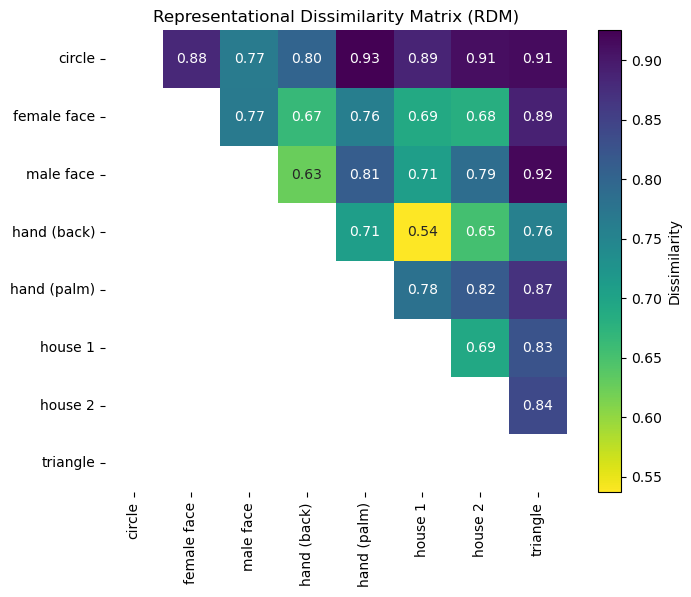

In [32]:
import seaborn as sns

# Mask the upper triangle
mask = np.tril(np.ones_like(rdm, dtype=bool))

# Visualize the RDM
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    rdm, 
    mask=mask,
    xticklabels=stim_names, 
    yticklabels=stim_names, 
    cmap='viridis_r', 
    square=True,
    cbar=False,  # Disable seaborn's default colorbar
    annot=True, fmt=".2f"
)

# Add a single labeled colorbar
colorbar = plt.colorbar(ax.collections[0], label="Dissimilarity")
plt.title("Representational Dissimilarity Matrix (RDM)")
plt.show()